Прогнозирование акций Лукойл

In [1]:
#Загружаем библиотеки

import pandas as pd #Пандас
import tensorflow as tf
import matplotlib.pyplot as plt #Отрисовка графиков
from keras import regularizers
from tensorflow.keras import utils #Для to_categorical
import numpy as np #Numpy
import keras.utils
from keras.optimizers import Adam #Оптимизатор
from keras.models import Sequential, Model #Два варианты моделей
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, \
	LeakyReLU, Activation  # Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
import seaborn as sns
# Рисовать графики сразу же
%matplotlib inline

import os
print ("Ok")

Ok


In [2]:
#Загружаем датафрейм
frame = pd.read_csv('Gosloto_6x45.csv', header=0, sep=';')
frame

,tiraz,datetime,1-number,2-number,3-number,4-number,5-number,6-number
0,1,10.11.2008 08:50,15,17,22,23,25,33
1,2,13.11.2008 08:50,23,29,44,19,24,45
2,3,17.11.2008 08:50,38,7,3,45,26,4
3,4,20.11.2008 08:50,31,26,44,37,40,27
4,5,24.11.2008 08:50,16,17,12,21,23,35
...,...,...,...,...,...,...,...,...
5424,5425,13.10.2020 11:00,18,7,16,23,37,43
5425,5426,13.10.2020 23:00,15,13,35,33,34,28
5426,5427,14.10.2020 11:00,27,44,40,29,41,25
5427,5428,14.10.2020 23:00,1,10,33,37,40,44


In [3]:
# удвляем дату и тираж
frame = frame.drop(columns=['datetime', 'tiraz'], axis=1).astype(float)
frame

,1-number,2-number,3-number,4-number,5-number,6-number
0,15.0,17.0,22.0,23.0,25.0,33.0
1,23.0,29.0,44.0,19.0,24.0,45.0
2,38.0,7.0,3.0,45.0,26.0,4.0
3,31.0,26.0,44.0,37.0,40.0,27.0
4,16.0,17.0,12.0,21.0,23.0,35.0
...,...,...,...,...,...,...
5424,18.0,7.0,16.0,23.0,37.0,43.0
5425,15.0,13.0,35.0,33.0,34.0,28.0
5426,27.0,44.0,40.0,29.0,41.0,25.0
5427,1.0,10.0,33.0,37.0,40.0,44.0


<AxesSubplot:>

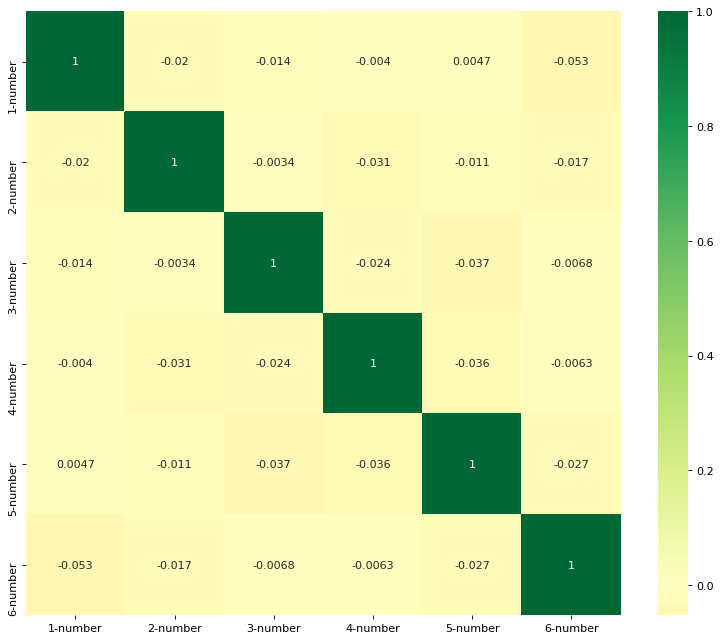

In [5]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(frame.corr(), xticklabels=frame.corr().columns, yticklabels=frame.corr().columns, cmap='RdYlGn', center=0, annot=True)

In [6]:
frame.describe()

,1-number,2-number,3-number,4-number,5-number,6-number
count,5429.000000,5429.000000,5429.000000,5429.000000,5429.000000,5429.000000
mean,22.982133,22.946952,23.113096,22.815620,23.348499,23.023577
std,13.006087,13.174812,12.846011,13.067398,13.046193,12.839588
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,12.000000,11.000000,12.000000,12.000000,12.000000,12.000000
50%,23.000000,23.000000,23.000000,22.000000,24.000000,23.000000
75%,34.000000,35.000000,34.000000,34.000000,35.000000,34.000000
max,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000


In [64]:
a = frame["1-number"].to_numpy()
b = frame["2-number"].to_numpy()
c = frame["3-number"].to_numpy()
d = frame["4-number"].to_numpy()
e = frame["5-number"].to_numpy()
f = frame["6-number"].to_numpy()
# for numa in a:
#     np.append(allnum, [numa])
con = np.stack([a, b, c,d,e,f], axis=1)
print(con.shape)
#con= np.array(range(0,60000,1)).reshape(10000,6)
con = np.random.uniform(0,3,120000)#.reshape(20000,6)
#con = con.reshape(32574,6)

(5429, 6)


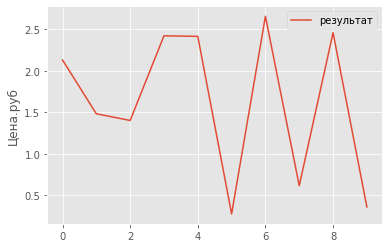

In [65]:
start = 0 #С какой точки начинаем
step = con.shape[0] #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
#chanelNames = list(allnum.columns)
plt.plot(con[0:10],
          label="результат")
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

**Функция загрузки данных**

In [66]:
def DataNormalization(data, Channels, Normalization):
  #Выбираем тип нормализации x
  #0 - нормальное распределение
  #1 - нормирование до отрезка 0-1
  if (Normalization == 0):
    scaler = StandardScaler()
  else:
    scaler = MinMaxScaler()

  #Берём только те каналы, которые указаны в аргументе функции
  resData = data[:,Channels]
  #Обучаем нормировщик
  scaler.fit(resData)
  #Нормируем данные
  resData = scaler.transform(resData)

  return (resData, scaler)

#Функция "раскусывания" данных для временных рядов
#data - данные
#xLen - размер фрема, по которому предсказываем
#xChannels - лист, номера каналов, по которым делаем анализ
#yChannels - лист, номера каналов, которые предсказываем
#stepsForward - на сколько шагов предсказываем в будущее
#если 1 - то на 1 шаг, можно использовать только при одном канале, указанном в yChannels
#xNormalization - нормализация входных каналов, 0 - нормальное распределение, 1 - к отрезку [0;1]
#yNormalization - нормализация прогнозируемых каналов, 0 - нормальное распределение, 1 - к отрезку [0;1]
#returnFlatten - делать ли одномерный вектор на выходе для Dense сетей
#valLen - сколько примеров брать для проверочной выборки (количество для обучающей посчитается автоматиески)
#convertToDerivative - bool, преобразовывали ли входные сигналы в производнуюa
def getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative):

  #Если указано превращение данных в производную
  #То вычитаем поточечно из текущей точки предыдущую
  if (convertToDerivative):
    data = np.array([(d[1:]-d[:-1]) for d in data.T]).copy().T

  #Нормализуем x
  (xData, xScaler) = DataNormalization(data, xChannels, xNormalization)

  #Нормализуем y
  (yData, yScaler) = DataNormalization(data, yChannels, yNormalization)

  #Формируем xTrain
  #Раскусываем исходный ряд на куски xLen с шагом в 1
  xTrain = np.array([xData[i:i + xLen, xChannels] for i in range(xData.shape[0] - xLen + 1 - stepsForward)])

  #Формируем yTrain
  #Берём stepsForward шагов после завершения текущего x
  if (stepsForward > 1):
    yTrain = np.array([yData[i:i + stepsForward, yChannels] for i in range(xLen, yData.shape[0] + 1 - stepsForward)])
  else:
    yTrain = np.array([yData[i, yChannels] for i in range(xLen, yData.shape[0] + 1 - stepsForward)])

  #Расчитываем отступ между обучающими о проверочными данными
  #Чтобы они не смешивались
  xTrainLen = xTrain.shape[0]
  bias = xLen + stepsForward + 2

  #Берём из конечной части xTrain проверочную выборку
  xVal = xTrain[xTrainLen-valLen:]
  yVal = yTrain[xTrainLen-valLen:]

  #Оставшуюся часть используем под обучающую выборку
  xTrain = xTrain[:xTrainLen-valLen-bias]
  yTrain = yTrain[:xTrainLen-valLen-bias]

  #Если в функцию передали вернуть flatten сигнал (для Dense сети)
  #xTrain и xVal превращаем в flatten
  if (returnFlatten > 0):
    xTrain = np.array([x.flatten() for x in xTrain])
    xVal = np.array([x.flatten() for x in xVal])

  return (xTrain, yTrain), (xVal, yVal), (xScaler, yScaler)

In [67]:
#Формируем параметры загрузки данных
xLen = 300 #Анализируем по 300 прошедшим точкам
stepsForward = 1 #Предсказываем на 1 шаг вперёд
xChannels = range(con.shape[1]) #Используемвсе входные каналы
yChannels = [0] #Предказываем только open канал
xNormalization = 1 #Нормируем входные каналы стандартным распределением
yNormalization = 1#Нормируем выходные каналы стандартным распределением
valLen = 100 #Используем 30.000 записей для проверки0
returnFlatten = 0 #Вернуть одномерные вечеторы
convertToDerivative = 0 #Не превращать в производную

#Загружаем данные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = \
    getXTrainFromTimeSeries(con, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)

#Выводим размеры данных для проверки
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)
xTrain.shape[1]
xTrainUnscaled = xScaler.inverse_transform(xTrain[0])

IndexError: tuple index out of range

Epoch 1/50
49/49 [==============================] - 4s 90ms/step - loss: 0.4324 - val_loss: 0.3716

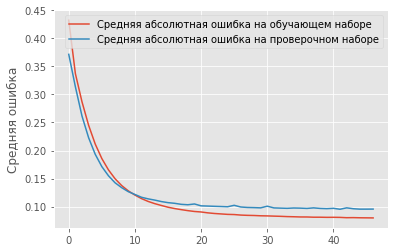

In [75]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
modelC = Sequential()
modelC.add(Conv1D(6, 200, input_shape = (xTrain.shape[1], xTrain.shape[2]), activation="linear"))
#modelC.add(BatchNormalization())
#modelC.add(LeakyReLU())
#modelC.add(LSTM(25, input_shape=(xTrain.shape[1], xTrain.shape[2])))
#modelC.add(Conv1D(None, 300))
#modelC.add(LSTM(20, input_shape=(8897,2000,6)))
modelC.add(Flatten())
modelC.add(Dense(20, activation="linear"))
#modelC.add(Dense(4, activity_regularizer=regularizers.l2(0.001)))
#modelC.add(BatchNormalization())
#modelC.add(LeakyReLU())
modelC.add(Dense(yTrain.shape[1], activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

#Новая архитектура сети

#modelC.add(Conv1D(1, 100, input_shape = (xTrain.shape[1], xTrain.shape[2]), activation="linear"))
# modelC.add(Dense(200, input_dim=3,
#                 activity_regularizer=regularizers.l2(0.01)))
# modelC.add(BatchNormalization())
#modelC.add(LeakyReLU())
# modelC.add(Dense(16,
#                 activity_regularizer=regularizers.l2(0.01)))
# modelC.add(BatchNormalization())
# modelC.add(LeakyReLU())
# modelC.add(Dense(1))
# modelC.add(Activation('linear'))
# modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

callbacks = [
  # Остановить обучение если `val_loss` перестанет улучшаться в течение 2 эпох
  tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
  # Записать логи TensorBoard в каталог `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

history = modelC.fit(xTrain,
                    yTrain,
                    epochs=50,
                    batch_size=400,
                    verbose=1,
                    callbacks=callbacks, 
                    validation_data=(xVal, yVal))

plt.plot(history.history['loss'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [69]:
#Функция рассчитываем результаты прогнозирования сети
#В аргументы принимает сеть (currModel) и проверочную выборку
#Выдаёт результаты предсказания predVal
#И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  #Предсказываем ответ сети по проверочной выборке
  #И возвращаем исходны масштаб данных, до нормализации
	predVal = yScaler.inverse_transform(currModel.predict(xVal))
	yValUnscaled = yScaler.inverse_transform(yVal)
	return (predVal, yValUnscaled)

#Функция расёта коэффициента корреляции Пирсона двух одномерных векторов
def correlate(a, b):
  return np.corrcoef(a, b)[0, 1]

In [70]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler)

In [71]:
modelC.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 101, 6)            7206      
_________________________________________________________________
flatten_5 (Flatten)          (None, 606)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                12140     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total params: 19,367
Trainable params: 19,367
Non-trainable params: 0
_________________________________________________________________


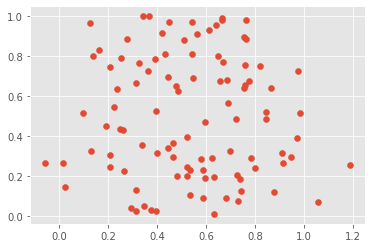

In [72]:
import matplotlib

matplotlib.style.use('ggplot')

#plt.figure(figsize=(12,12))
plt.scatter(predVal, yValUnscaled)
plt.show()

In [73]:

#Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
#start - точка с которой начинаем отрисовку графика
#step - длина графика, которую отрисовываем
#channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel],
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

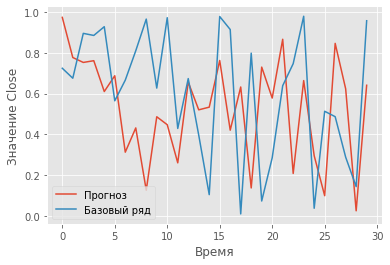

           0         1         2         3
0   0.974348  0.724637  0.249710 -0.249710
1   0.777274  0.675719  0.101555 -0.101555
2   0.753199  0.895847 -0.142648  0.142648
3   0.761700  0.885641 -0.123941  0.123941
4   0.610415  0.928614 -0.318199  0.318199
5   0.687878  0.564924  0.122954 -0.122954
6   0.312835  0.666264 -0.353429  0.353429
7   0.431819  0.810496 -0.378676  0.378676
8   0.126038  0.965890 -0.839852  0.839852
9   0.486613  0.627296 -0.140682  0.140682
10  0.447577  0.972739 -0.525162  0.525162
11  0.260446  0.429242 -0.168795  0.168795
12  0.656420  0.673979 -0.017559  0.017559
13  0.520631  0.396500  0.124131 -0.124131
14  0.533789  0.104389  0.429401 -0.429401
15  0.762678  0.978519 -0.215841  0.215841
16  0.420787  0.914703 -0.493916  0.493916
17  0.632660  0.009847  0.622813 -0.622813
18  0.137241  0.798821 -0.661580  0.661580
19  0.730250  0.073196  0.657054 -0.657054
20  0.578342  0.285153  0.293189 -0.293189
21  0.866929  0.638951  0.227978 -0.227978
22  0.20840

In [74]:
#Отображаем графики
showPredict(0, 30, 0, predVal, yValUnscaled)
#print (predVal, yValUnscaled)
yes = pd.DataFrame(predVal)
yes['1'] = yValUnscaled
yes['2'] = predVal - yValUnscaled
yes['3'] = yValUnscaled - predVal
#print (yes[:60].sort_values('1'))
print (yes[:30])

In [47]:
#Функция строит корреляцию прогнозированного сигнала с правильным
#Смещая на различное количество шагов назад
#Для проверки появления эффекта автокорреляции
#channels - по каким каналам отображать корреляцию
#corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  #Проходим по всем каналам
  for ch in channels:
    corr = [] #Создаём пустой лист, в нём будут корреляции при смещении на i рагов обратно
    yLen = yValUnscaled.shape[0] #Запоминаем размер проверочной выборки

    #Постепенно увеличиваем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      #Получаем сигнал, смещённый на i шагов назад
      #predVal[i:, ch]
      #Сравниваем его с верными ответами, без смещения назад
      #yValUnscaled[:yLen-i,ch]
      #Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    #Отображаем график корреляций для данного шага
    plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [379]:
#Отображаем корреляцию
showCorr([1], 10, predVal, yValUnscaled)

IndexError: index 1 is out of bounds for axis 1 with size 1